# Getting started with MLlib - binary classification example

This tutorial is designed to get you started with Apache Spark MLlib. It investigates a binary classification problem - can you predict if an individual's income is greater than $50,000 based on demographic data? The dataset is from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Adult) and is provided with Databricks Runtime. This notebook demonstrates some of the capabilities available in MLlib, including tools for data preprocessing, machine learning pipelines, and several different machine learning algorithms.

This notebook includes the following steps:

0. Load the dataset
0. Feature preprocessing
0. Define the model
0. Build the pipeline
0. Evaluate the model
0. Hyperparameter tuning
0. Make predictions and evaluate model performance

## Requirements
Databricks Runtime 7.0 or above or Databricks Runtime 7.0 ML or above. If you are running Databricks Runtime 6.x or Databricks Runtime 6.x ML, see ([AWS](https://docs.databricks.com/getting-started/spark/machine-learning.html)|[Azure](https://docs.microsoft.com/azure/databricks/getting-started/spark/machine-learning/)) for the correct notebook.

## Step 1. Load the dataset

Use Databricks utilities to view the first few rows of the data.

In [0]:
%fs head --maxBytes=1024 databricks-datasets/adult/adult.data

[Truncated to first 1024 bytes]
39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K
38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, <=50K
53, Private, 234721, 11th, 7, Married-civ-spouse, Handlers-cleaners, Husband, Black, Male, 0, 0, 40, United-States, <=50K
28, Private, 338409, Bachelors, 13, Married-civ-spouse, Prof-specialty, Wife, Black, Female, 0, 0, 40, Cuba, <=50K
37, Private, 284582, Masters, 14, Married-civ-spouse, Exec-managerial, Wife, White, Female, 0, 0, 40, United-States, <=50K
49, Private, 160187, 9th, 5, Married-spouse-absent, Other-service, Not-in-family, Black, Female, 0, 0, 16, Jamaica, <=50K
52, Self-emp-not-inc, 209642, HS-grad, 9, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 45, United-States, >50K
31, Private, 45781, Masters,

Because the dataset does not include column names, create a schema to assign column names and datatypes.

In [0]:
schema = """`age` DOUBLE,
`workclass` STRING,
`fnlwgt` DOUBLE,
`education` STRING,
`education_num` DOUBLE,
`marital_status` STRING,
`occupation` STRING,
`relationship` STRING,
`race` STRING,
`sex` STRING,
`capital_gain` DOUBLE,
`capital_loss` DOUBLE,
`hours_per_week` DOUBLE,
`native_country` STRING,
`income` STRING"""

dataset = spark.read.csv("/databricks-datasets/adult/adult.data", schema=schema)

Randomly split data into training and test sets, and set seed for reproducibility.

It's best to split the data before doing any preprocessing. This allows the test dataset to more closely simulate new data when we evaluate the model.

In [0]:
### START CODE ###
# Use dataset.randomSplit() to split the data into 80% train and 20% test set and set seed as 42.
trainDF, testDF = dataset.randomSplit([0.8, 0.2], seed = 42) 
print(trainDF.cache().count()) # Cache because accessing training data multiple times
print(testDF.count())

26076
6485

Let's review the data.

In [0]:
display(trainDF)

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
17.0,?,34019.0,10th,6.0,Never-married,?,Own-child,White,Male,0.0,0.0,20.0,United-States,<=50K
17.0,?,34088.0,12th,8.0,Never-married,?,Own-child,White,Female,0.0,0.0,25.0,United-States,<=50K
17.0,?,47407.0,11th,7.0,Never-married,?,Own-child,White,Male,0.0,0.0,10.0,United-States,<=50K
17.0,?,48703.0,11th,7.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
17.0,?,48751.0,11th,7.0,Never-married,?,Own-child,Black,Female,0.0,0.0,40.0,United-States,<=50K
17.0,?,67808.0,10th,6.0,Never-married,?,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K
17.0,?,86786.0,10th,6.0,Never-married,?,Own-child,White,Female,0.0,0.0,40.0,United-States,<=50K
17.0,?,89870.0,10th,6.0,Never-married,?,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K
17.0,?,94366.0,10th,6.0,Never-married,?,Other-relative,White,Male,0.0,0.0,6.0,United-States,<=50K
17.0,?,103810.0,12th,8.0,Never-married,?,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K


What's the distribution of the number of `hours_per_week`?

In [0]:
display(trainDF.select("hours_per_week").summary())

summary,hours_per_week
count,26076
mean,40.4284782942169
stddev,12.404569739132008
min,1.0
25%,40.0
50%,40.0
75%,45.0
max,99.0


How about `education` status?

In [0]:
### START CODE ###
# You can groupBy by education, get the count and sort it in descending order.
display(trainDF.groupBy("education").count().sort('count', ascending=False))
### END CODE ###

education,count
HS-grad,8408
Some-college,5860
Bachelors,4255
Masters,1388
Assoc-voc,1102
11th,958
Assoc-acdm,845
10th,748
7th-8th,510
Prof-school,465


26076
Out[17]:

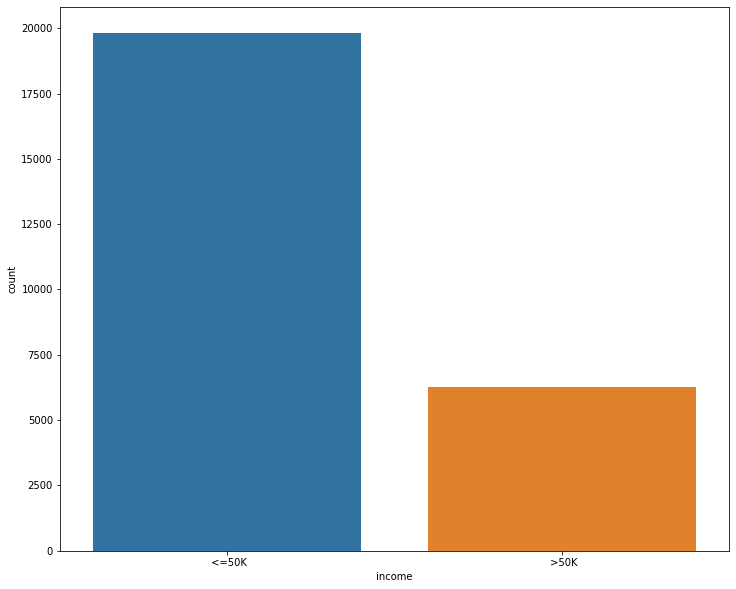

<matplotlib.axes._subplots.AxesSubplot at 0x7fd1c4f0a100>

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(12,10))
df_pd = trainDF.toPandas()
print(len(df_pd))
plt.figure(figsize=(12,10))
sns.countplot(x='income', data=df_pd, order=df_pd['income'].value_counts().index)

## Background: Transformers, estimators, and pipelines

Three important concepts in MLlib machine learning that are illustrated in this notebook are **Transformers**, **Estimators**, and **Pipelines**. 

- **Transformer**: Takes a DataFrame as input, and returns a new DataFrame. Transformers do not learn any parameters from the data and simply apply rule-based transformations to either prepare data for model training or generate predictions using a trained MLlib model. You call a transformer with a `.transform()` method.

- **Estimator**: Learns (or "fits") parameters from your DataFrame via a `.fit()` method and returns a Model, which is a transformer.

- **Pipeline**: Combines multiple steps into a single workflow that can be easily run. Creating a machine learning model typically involves setting up many different steps and iterating over them. Pipelines help you automate this process.

For more information:
[ML Pipelines](https://spark.apache.org/docs/latest/ml-pipeline.html#ml-pipelines)

## Step 2. Feature preprocessing 

The goal of this notebook is to build a model that predicts the `income` level from the features included in the dataset (education level, marital status, occupation, and so on). The first step is to manipulate, or preprocess, the features so they are in the format MLlib requires.

### Convert categorical variables to numeric

Some machine learning algorithms, such as linear and logistic regression, require numeric features. The Adult dataset includes categorical features such as education, occupation, and marital status. 

The following code block illustrates how to use `StringIndexer` and `OneHotEncoder` to convert categorical variables into a set of numeric variables that only take on values 0 and 1. 

- `StringIndexer` converts a column of string values to a column of label indexes. For example, it might convert the values "red", "blue", and "green" to 0, 1, and 2. 
- `OneHotEncoder` maps a column of category indices to a column of binary vectors, with at most one "1" in each row that indicates the category index for that row.

One-hot encoding in Spark is a two-step process. You first use the StringIndexer, followed by the OneHotEncoder. The following code block defines the StringIndexer and OneHotEncoder but does not apply it to any data yet.

For more information:   
[StringIndexer](http://spark.apache.org/docs/latest/ml-features.html#stringindexer)   
[OneHotEncoder](https://spark.apache.org/docs/latest/ml-features.html#onehotencoder)

In [0]:
'''
from pyspark.ml.feature import StringIndexer, OneHotEncoder

categoricalCols = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex"]

# The following two lines are estimators. They return functions that we will later apply to transform the dataset.
# Use categoricalCols as the inputCols for StringIndexer
stringIndexer = StringIndexer(inputCols = categoricalCols , outputCols=[x + "Index" for x in categoricalCols])
# Use stringIndexer.getOutputCols() as the inputCols for OneHotEncoder
encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[x + "OHE" for x in categoricalCols]) 

# The label column ("income") is also a string value - it has two possible values, "<=50K" and ">50K". 
# Convert it to a numeric value using StringIndexer.
labelToIndex = StringIndexer(inputCol="income", outputCol="label")
'''

Out[2]: '\nfrom pyspark.ml.feature import StringIndexer, OneHotEncoder\n\ncategoricalCols = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex"]\n\n# The following two lines are estimators. They return functions that we will later apply to transform the dataset.\n# Use categoricalCols as the inputCols for StringIndexer\nstringIndexer = StringIndexer(inputCols = categoricalCols , outputCols=[x + "Index" for x in categoricalCols])\n# Use stringIndexer.getOutputCols() as the inputCols for OneHotEncoder\nencoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[x + "OHE" for x in categoricalCols]) \n\n# The label column ("income") is also a string value - it has two possible values, "<=50K" and ">50K". \n# Convert it to a numeric value using StringIndexer.\nlabelToIndex = StringIndexer(inputCol="income", outputCol="label")\n'

In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

categoricalCols = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex"]

stages = []

# The following two lines are estimators. They return functions that we will later apply to transform the dataset.
for categoricalCol in categoricalCols:
    # Use categoricalCols as the inputCols for StringIndexer
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    # Use stringIndexer.getOutputCols() as the inputCols for OneHotEncoder
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "OHE"])
    stages += [stringIndexer, encoder]

# The label column ("income") is also a string value - it has two possible values, "<=50K" and ">50K". 
# Convert it to a numeric value using StringIndexer.
labelToIndex = StringIndexer(inputCol="income", outputCol="label")

stages += [labelToIndex]

In this notebook, we'll build a pipeline combining all of our feature engineering and modeling steps. But let's take a minute to look more closely at how estimators and transformers work by applying the `stringIndexer` estimator that we created in the previous code block.

You can call the `.fit()` method to return a `StringIndexerModel`, which you can then use to transform the dataset. 

The `.transform()` method of `StringIndexerModel` returns a new DataFrame with the new columns appended. Scroll right to see the new columns if necessary. 

For more information: [StringIndexerModel](https://spark.apache.org/docs/latest/api/java/org/apache/spark/ml/feature/StringIndexerModel.html)

In [0]:
### START CODE ###
# Fit the string indexer on trainDF
#stringIndexerModel = labelToIndex.fit(trainDF)
stringIndexerModel = stringIndexer.fit(trainDF)
### END CODE ###
display(stringIndexerModel.transform(trainDF))

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,educationIndex,raceIndex,occupationIndex,relationshipIndex,workclassIndex,marital_statusIndex,sexIndex
17.0,?,34019.0,10th,6.0,Never-married,?,Own-child,White,Male,0.0,0.0,20.0,United-States,<=50K,7.0,0.0,7.0,2.0,3.0,1.0,0.0
17.0,?,34088.0,12th,8.0,Never-married,?,Own-child,White,Female,0.0,0.0,25.0,United-States,<=50K,11.0,0.0,7.0,2.0,3.0,1.0,1.0
17.0,?,47407.0,11th,7.0,Never-married,?,Own-child,White,Male,0.0,0.0,10.0,United-States,<=50K,5.0,0.0,7.0,2.0,3.0,1.0,0.0
17.0,?,48703.0,11th,7.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K,5.0,0.0,7.0,2.0,3.0,1.0,1.0
17.0,?,48751.0,11th,7.0,Never-married,?,Own-child,Black,Female,0.0,0.0,40.0,United-States,<=50K,5.0,1.0,7.0,2.0,3.0,1.0,1.0
17.0,?,67808.0,10th,6.0,Never-married,?,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K,7.0,0.0,7.0,2.0,3.0,1.0,0.0
17.0,?,86786.0,10th,6.0,Never-married,?,Own-child,White,Female,0.0,0.0,40.0,United-States,<=50K,7.0,0.0,7.0,2.0,3.0,1.0,1.0
17.0,?,89870.0,10th,6.0,Never-married,?,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K,7.0,0.0,7.0,2.0,3.0,1.0,0.0
17.0,?,94366.0,10th,6.0,Never-married,?,Other-relative,White,Male,0.0,0.0,6.0,United-States,<=50K,7.0,0.0,7.0,5.0,3.0,1.0,0.0
17.0,?,103810.0,12th,8.0,Never-married,?,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K,11.0,0.0,7.0,2.0,3.0,1.0,0.0


### Combine all feature columns into a single feature vector

Most MLlib algorithms require a single features column as input. Each row in this column contains a vector of data points corresponding to the set of features used for prediction. 

MLlib provides the `VectorAssembler` transformer to create a single vector column from a list of columns.

The following code block illustrates how to use VectorAssembler.

For more information: [VectorAssembler](https://spark.apache.org/docs/latest/ml-features.html#vectorassembler)

In [0]:
from pyspark.ml.feature import VectorAssembler

# This includes both the numeric columns and the one-hot encoded binary vector columns in our dataset.
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "OHE" for c in categoricalCols] + numericCols
### START CODE ###
# Use assemblerInputs as inputCols and "features" as outputCol
vecAssembler = VectorAssembler(inputCols = assemblerInputs , outputCol = 'features')
stages += [vecAssembler]
### END CODE ###

## Step 3. Define the model

This notebook uses a [logistic regression](https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression) model.

In [0]:
from pyspark.ml.classification import LogisticRegression
### START CODE ###
# Define a LogisticRegression model and specify featuresCol as "features", labelCol as "label" and regParam as 1.0
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10, regParam=1.0)
### END CODE ###

## Step 4. Build the pipeline

A `Pipeline` is an ordered list of transformers and estimators. You can define a pipeline to automate and ensure repeatability of the transformations to be applied to a dataset. In this step, we define the pipeline and then apply it to the test dataset.

Similar to what we saw with `StringIndexer`, a `Pipeline` is an estimator. The `pipeline.fit()` method returns a `PipelineModel`, which is a transformer.

For more information:   
[Pipeline](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.Pipeline)  
[PipelineModel](https://spark.apache.org/docs/latest/api/java/org/apache/spark/ml/PipelineModel.html)

In [0]:
from pyspark.ml import Pipeline

### START CODE ###
# Define the pipeline based on the stages created in previous steps.
pipeline = Pipeline(stages=stages)


# Define the pipeline model and fit on trainDF.
pipelineModel = pipeline.fit(dataset)
dataset = pipelineModel.transform(dataset) 

trainDF, testDF = dataset.randomSplit([0.8, 0.2], seed = 42)
lr_model = lr.fit(trainDF)

# Apply the pipeline model to the test dataset using transform.
predDF = lr_model.transform(testDF)
### END CODE ###

In [0]:
cols = dataset.columns
selectedCols = ['features']+cols
new_df = dataset.select(selectedCols)
pd.DataFrame(new_df.take(5), columns=new_df.columns)

In [0]:
'''
from pyspark.ml import Pipeline

### START CODE ###
# Define the pipeline based on the stages created in previous steps.
# Hint: Use stringIndexer, encoder, labelToIndex, vecAssembler, lr
stages = []
stages += [stringIndexer, encoder]
stages += [labelToIndex]
stages += [vecAssembler]
stages += [lr]


#labelToIndexModel = labelToIndex.fit(trainDF)
pipeline = Pipeline(stages=stages)
#pipeline = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, lr])

# Define the pipeline model and fit on trainDF.
pipelineModel = pipeline.fit(trainDF)

# Apply the pipeline model to the test dataset using transform.
predDF = pipelineModel.transform(testDF)
### END CODE ###
'''

Display the predictions from the model. The `features` column is a [sparse vector](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.linalg.SparseVector), which is often the case after one-hot encoding, because there are so many 0 values.

In [0]:
display(predDF.select("features", "label", "prediction", "probability"))

features,label,prediction,probability
"Map(vectorType -> sparse, length -> 59, indices -> List(3, 13, 24, 36, 45, 48, 53, 54, 55, 58), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 17.0, 41643.0, 7.0, 15.0))",0.0,0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.9033190608656012, 0.09668093913439879))"
"Map(vectorType -> sparse, length -> 59, indices -> List(3, 15, 24, 36, 45, 48, 52, 53, 54, 55, 58), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 17.0, 64785.0, 6.0, 30.0))",0.0,0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.8926653751465021, 0.10733462485349787))"
"Map(vectorType -> sparse, length -> 59, indices -> List(3, 13, 24, 36, 45, 48, 53, 54, 55, 58), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 17.0, 80077.0, 7.0, 20.0))",0.0,0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.9012177681494944, 0.09878223185050561))"
"Map(vectorType -> sparse, length -> 59, indices -> List(3, 13, 24, 36, 45, 48, 52, 53, 54, 55, 58), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 17.0, 104025.0, 7.0, 18.0))",0.0,0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.8939801642038776, 0.1060198357961224))"
"Map(vectorType -> sparse, length -> 59, indices -> List(3, 15, 24, 36, 45, 48, 53, 54, 55, 58), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 17.0, 139183.0, 6.0, 15.0))",0.0,0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.9066977011772427, 0.09330229882275731))"
"Map(vectorType -> sparse, length -> 59, indices -> List(3, 8, 24, 36, 45, 49, 52, 53, 54, 55, 58), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 17.0, 148769.0, 9.0, 40.0))",0.0,0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.8834188556715754, 0.11658114432842459))"
"Map(vectorType -> sparse, length -> 59, indices -> List(3, 13, 24, 36, 45, 48, 53, 54, 55, 58), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 17.0, 170320.0, 7.0, 8.0))",0.0,0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.9059163069489801, 0.09408369305101993))"
"Map(vectorType -> sparse, length -> 59, indices -> List(3, 13, 24, 36, 45, 48, 52, 53, 54, 55, 58), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 17.0, 198797.0, 7.0, 20.0))",0.0,0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.8929377909870159, 0.10706220901298413))"
"Map(vectorType -> sparse, length -> 59, indices -> List(3, 19, 24, 36, 45, 53, 54, 55, 58), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 17.0, 241021.0, 8.0, 40.0))",0.0,0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.8867987928524033, 0.11320120714759674))"
"Map(vectorType -> sparse, length -> 59, indices -> List(3, 13, 24, 36, 45, 49, 52, 53, 54, 55, 58), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 17.0, 250541.0, 7.0, 8.0))",0.0,0.0,"Map(vectorType -> dense, length -> 2, values -> List(0.9062446328459096, 0.09375536715409039))"


## Step 5. Evaluate the model

The `display` command has a built-in ROC curve option.

In [0]:
#display(pipelineModel.stages[-1], predDF.drop("prediction", "rawPrediction", "probability"), "ROC")
display(predDF.drop("prediction", "rawPrediction", "probability"), "ROC")

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,workclassIndex,workclassOHE,educationIndex,educationOHE,marital_statusIndex,marital_statusOHE,occupationIndex,occupationOHE,relationshipIndex,relationshipOHE,raceIndex,raceOHE,sexIndex,sexOHE,label,features
17.0,?,41643.0,11th,7.0,Never-married,?,Own-child,White,Female,0.0,0.0,15.0,United-States,<=50K,3.0,"Map(vectorType -> sparse, length -> 8, indices -> List(3), values -> List(1.0))",5.0,"Map(vectorType -> sparse, length -> 15, indices -> List(5), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 6, indices -> List(1), values -> List(1.0))",7.0,"Map(vectorType -> sparse, length -> 14, indices -> List(7), values -> List(1.0))",2.0,"Map(vectorType -> sparse, length -> 5, indices -> List(2), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 1, indices -> List(), values -> List())",0.0,"Map(vectorType -> sparse, length -> 59, indices -> List(3, 13, 24, 36, 45, 48, 53, 54, 55, 58), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 17.0, 41643.0, 7.0, 15.0))"
17.0,?,64785.0,10th,6.0,Never-married,?,Own-child,White,Male,0.0,0.0,30.0,United-States,<=50K,3.0,"Map(vectorType -> sparse, length -> 8, indices -> List(3), values -> List(1.0))",7.0,"Map(vectorType -> sparse, length -> 15, indices -> List(7), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 6, indices -> List(1), values -> List(1.0))",7.0,"Map(vectorType -> sparse, length -> 14, indices -> List(7), values -> List(1.0))",2.0,"Map(vectorType -> sparse, length -> 5, indices -> List(2), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 59, indices -> List(3, 15, 24, 36, 45, 48, 52, 53, 54, 55, 58), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 17.0, 64785.0, 6.0, 30.0))"
17.0,?,80077.0,11th,7.0,Never-married,?,Own-child,White,Female,0.0,0.0,20.0,United-States,<=50K,3.0,"Map(vectorType -> sparse, length -> 8, indices -> List(3), values -> List(1.0))",5.0,"Map(vectorType -> sparse, length -> 15, indices -> List(5), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 6, indices -> List(1), values -> List(1.0))",7.0,"Map(vectorType -> sparse, length -> 14, indices -> List(7), values -> List(1.0))",2.0,"Map(vectorType -> sparse, length -> 5, indices -> List(2), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 1, indices -> List(), values -> List())",0.0,"Map(vectorType -> sparse, length -> 59, indices -> List(3, 13, 24, 36, 45, 48, 53, 54, 55, 58), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 17.0, 80077.0, 7.0, 20.0))"
17.0,?,104025.0,11th,7.0,Never-married,?,Own-child,White,Male,0.0,0.0,18.0,United-States,<=50K,3.0,"Map(vectorType -> sparse, length -> 8, indices -> List(3), values -> List(1.0))",5.0,"Map(vectorType -> sparse, length -> 15, indices -> List(5), values -> List(1.0))",1.0,"Map(vectorType -> sparse, length -> 6, indices -> List(1), values -> List(1.0))",7.0,"Map(vectorType -> sparse, length -> 14, indices -> List(7), values -> List(1.0))",2.0,"Map(vectorType -> sparse, length -> 5, indices -> List(2), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 4, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 1, indices -> List(0), values -> List(1.0))",0.0,"Map(vectorType -> sparse, length -> 59, indices -> List(3, 13, 24, 36, 45, 48, 52, 53, 54, 55, 58), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 17.0, 104025.0, 7.0, 18.0))"
17.0,?,139183.0,10th,6.0,Never-married,?,Own-child,White,Female,0.0,0.0,15.0,United-States,<=50K,3.0,"Map(vectorType -> sparse, lengt

To evaluate the model, we use the `BinaryClassificationEvaluator` to evalute the area under the ROC curve and the `MulticlassClassificationEvaluator` to evalute the accuracy.

For more information:  
[BinaryClassificationEvaluator](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.BinaryClassificationEvaluator)  
[MulticlassClassificationEvaluator](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.MulticlassClassificationEvaluator)

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Use areaUnderROC as the metricName for BinaryClassificationEvaluator
bcEvaluator = BinaryClassificationEvaluator()
print(f"Area under ROC curve: {bcEvaluator.evaluate(predDF)}")

# Use accuracy as the metricName for MulticlassClassificationEvaluator
mcEvaluator = MulticlassClassificationEvaluator()
print(f"Accuracy: {mcEvaluator.evaluate(predDF)}")

Area under ROC curve: 0.8867417940969914
Accuracy: 0.683631851218585

## Step 6. Hyperparameter tuning

MLlib provides methods to facilitate hyperparameter tuning and cross validation. 
- For hyperparameter tuning, `ParamGridBuilder` lets you define a grid search over a set of model hyperparameters.
- For cross validation, `CrossValidator` lets you specify an estimator (the pipeline to apply to the input dataset), an evaluator, a grid space of hyperparameters, and the number of folds to use for cross validation.
  
For more information:   
[Model selection using cross-validation](https://spark.apache.org/docs/latest/ml-tuning.html)  
[ParamGridBuilder](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.tuning)  
[CrossValidator](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator)

Use `ParamGridBuilder` and `CrossValidator` to tune the model. This example uses three values for `regParam` and three for `elasticNetParam`, for a total of 3 x 3 = 9 hyperparameter combinations for `CrossValidator` to examine.

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

### START CODE ###
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])  # tune lr.regParam with [0.01, 0.5, 2.0]
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # tune lr.elasticNetParam with [0.0, 0.5, 1.0]
             .build())
### END CODE ###

Whenever you call `CrossValidator` in MLlib, Databricks automatically tracks all of the runs using [MLflow](https://mlflow.org/). You can use the MLflow UI ([AWS](https://docs.databricks.com/applications/mlflow/index.html)|[Azure](https://docs.microsoft.com/azure/databricks/applications/mlflow/)) to compare how each model performed.

In this example we use the pipeline we created as the estimator.

In [0]:
### START CODE ###
# Create a 3-fold CrossValidator
# Use pipeline as the estimator, paramGrid for estimatorParamMaps, bcEvaluator for evaluator, with 3 folds and use 4 for parallelism
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=bcEvaluator, numFolds=3, parallelism=4)

# Run cross validations. This step takes a few minutes and returns the best model found from the cross validation.
cvModel = cv.fit(trainDF)
### END CODE ###

## Step 7. Make predictions and evaluate model performance
Use the best model identified by the cross-validation to make predictions on the test dataset, and then evaluate the model's performance using the area under the ROC curve.

In [0]:
### START CODE ###
# Use the model identified by the cross-validation to make predictions on the test dataset
cvPredDF = cvModel.transform(testDF)

# Evaluate the model's performance based on area under the ROC curve and accuracy 
print(f"Area under ROC curve: {bcEvaluator.evaluate(cvPredDF)}")
print(f"Accuracy: {mcEvaluator.evaluate(cvPredDF)}")
### END CODE ###

Area under ROC curve: 0.9008575157663199
Accuracy: 0.8381176696064082

Using SQL commands, you can also display predictions grouped by age and occupation. This requires creating a temporary view of the predictions dataset.

In [0]:
cvPredDF.createOrReplaceTempView("finalPredictions")

In [0]:
%sql
SELECT occupation, prediction, count(*) AS count
FROM finalPredictions
GROUP BY occupation, prediction
ORDER BY occupation

occupation,prediction,count
?,0.0,350
?,1.0,13
Adm-clerical,1.0,51
Adm-clerical,0.0,734
Armed-Forces,0.0,3
Craft-repair,1.0,67
Craft-repair,0.0,776
Exec-managerial,0.0,382
Exec-managerial,1.0,414
Farming-fishing,1.0,7


In [0]:
%sql
SELECT age, prediction, count(*) AS count
FROM finalPredictions
GROUP BY age, prediction
ORDER BY age

age,prediction,count
17.0,0.0,57
18.0,0.0,96
19.0,0.0,134
20.0,0.0,139
21.0,0.0,147
21.0,1.0,1
22.0,0.0,148
23.0,0.0,191
23.0,1.0,1
24.0,1.0,5


In [0]:
%sql
SELECT marital_status, prediction, count(*) as count
FROM finalPredictions
GROUP BY marital_status, prediction
ORDER BY marital_status ASC

marital_status,prediction,count
Divorced,0.0,852
Divorced,1.0,26
Married-AF-spouse,0.0,5
Married-civ-spouse,1.0,1153
Married-civ-spouse,0.0,1872
Married-spouse-absent,1.0,2
Married-spouse-absent,0.0,74
Never-married,1.0,21
Never-married,0.0,2084
Separated,0.0,218


In [0]:
%sql
SELECT education, prediction, count(*) as count
FROM finalPredictions
GROUP BY education, prediction
ORDER BY education DESC

education,prediction,count
Some-college,1.0,157
Some-college,0.0,1274
Prof-school,1.0,79
Prof-school,0.0,32
Preschool,0.0,6
Preschool,1.0,2
Masters,0.0,141
Masters,1.0,194
HS-grad,1.0,108
HS-grad,0.0,1985


In [0]:
%sql
SELECT hours_per_week, prediction, count(*) as count
FROM finalPredictions
GROUP BY hours_per_week, prediction
ORDER BY hours_per_week

hours_per_week,prediction,count
1.0,0.0,4
2.0,0.0,4
2.0,1.0,1
3.0,0.0,5
4.0,0.0,12
5.0,0.0,10
6.0,0.0,13
7.0,1.0,1
7.0,0.0,6
8.0,0.0,32


In [0]:
%sql
SELECT fnlwgt, prediction, count(*) as count
FROM finalPredictions
GROUP BY fnlwgt, prediction
ORDER BY fnlwgt

fnlwgt,prediction,count
13769.0,0.0,1
19214.0,0.0,1
19302.0,0.0,1
20057.0,0.0,1
20308.0,0.0,1
20333.0,1.0,1
20956.0,1.0,1
21306.0,0.0,1
21626.0,0.0,2
21698.0,0.0,1


In [0]:
#https://towardsdatascience.com/build-an-end-to-end-machine-learning-model-with-mllib-in-pyspark-4917bdf289c5
#https://medium.com/@nutanbhogendrasharma/feature-transformer-vectorassembler-in-pyspark-ml-feature-part-3-b3c2c3c93ee9?p=3275767e74f0
#https://docs.databricks.com/applications/machine-learning/train-model/mllib/index.html#binary-classification-example
#https://tsmatz.github.io/azure-databricks-exercise/exercise10-mlflow.html
#https://spark.apache.org/docs/latest/ml-classification-regression.html#output-columns-predictions
#https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier
#https://github.com/nxs5899/end-to-end-Machine-Learning-model-with-MLlib-in-pySpark/blob/master/MLlib_pySpark.ipynb

In [0]:
#["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]